This notebook uses cvxpy library (it has been installed on urbana package, so it should be updated in order to use the entire program)

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

In [6]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [7]:
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

In [8]:
# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_SVR = DIR_MONTH / "05_svr"

if SAVE_FIGS:
    folder_list = [
        DIR_SVR,
        DIR_SVR / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [9]:
PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

In [10]:
PATH_TO_FILE = DIR_MONTH / "05_svr_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "05_0_svr_linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Initial visualizations

In [11]:
sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score             151
Airbnb_Price_Person               119
Airbnb_Price                      119
Rent_Area_Flats                    18
Rent_Price_Total_Flats             18
Rent_Price_Meter_Flats             18
Rent_Number_Flats                  10
Nationality_Venezuela               0
Nationality_Dominican_Republic      0
Nationality_Ecuador                 0
dtype: int64

In [12]:
geo_info = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

geo_info.set_index("Tag", inplace=True)

geo_coefs = geo_info.copy()
geo_tvals = geo_info.copy()
geo_nans = geo_info.copy()

In [13]:
# y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1)).flatten()
y = sect[VARIABLE_TO_PREDICT]
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
    ],
    axis=1,
)

print(X.shape)

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

(1068, 84)


In [14]:
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

id_max_airbnb = geo_info[VARIABLE_TO_PREDICT].idxmax()

print("Area with maximum value: " + str(id_max_airbnb))

Area with maximum value: 02_077


## Target variable

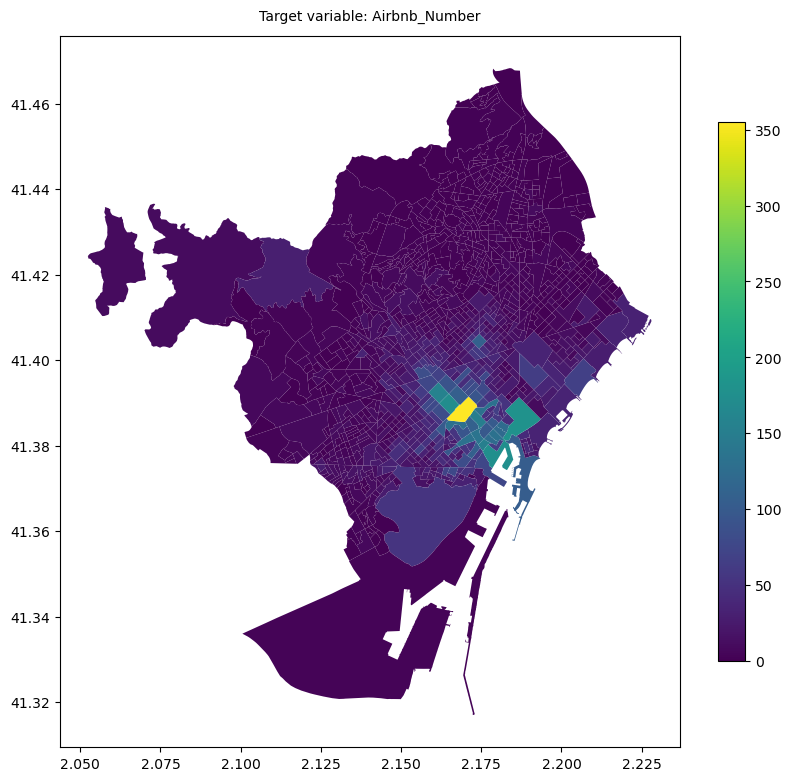

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=10, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "target_variable.svg", format="svg")

plt.show()

This plot shows the geographical distribution of the number of Airbnbs in Barcelona. It can be seen that there is a high concentration in the city center, and that it is apparently reduced when increasing the distance. In addition, the regions with a lower number of Airbnbs show a low variability.

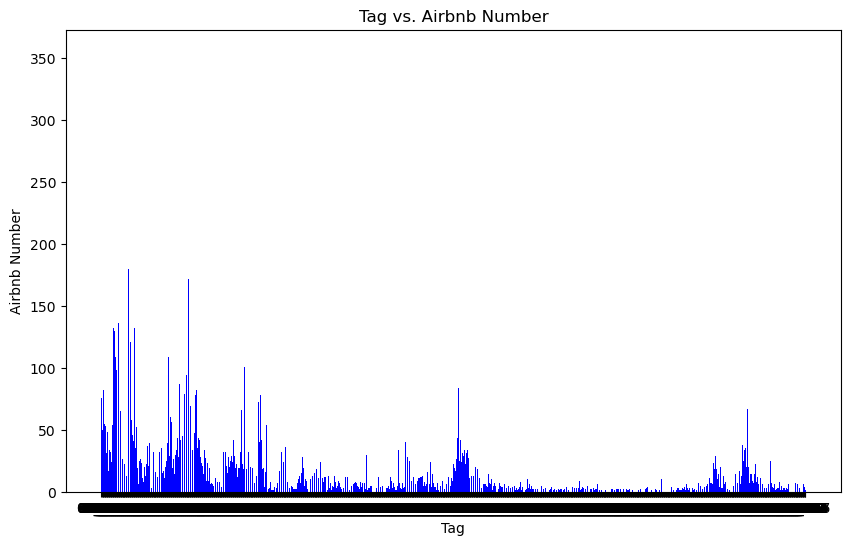

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(geo_info.index, geo_info["Airbnb_Number"], color="b")
plt.xlabel("Tag")
plt.ylabel("Airbnb Number")
plt.title("Tag vs. Airbnb Number")
plt.show()

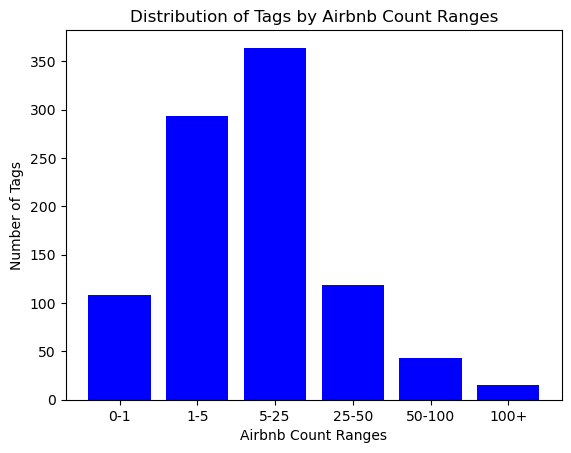

In [17]:
bins = [0, 1, 5, 25, 50, 100, 150]
labels = ["0-1", "1-5", "5-25", "25-50", "50-100", "100+"]

geo_info_rep = geo_info
geo_info_rep["Tag"] = geo_info_rep.index

geo_info_rep["Airbnb_Range"] = pd.cut(
    geo_info["Airbnb_Number"], bins=bins, labels=labels
)

tag_counts = geo_info.groupby("Airbnb_Range")["Tag"].count()

plt.bar(tag_counts.index, tag_counts.values, color="b")
plt.xlabel("Airbnb Count Ranges")
plt.ylabel("Number of Tags")
plt.title("Distribution of Tags by Airbnb Count Ranges")
plt.show()  # Display the plo

## NaNs

In [18]:
# define the colormap
cmap = plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

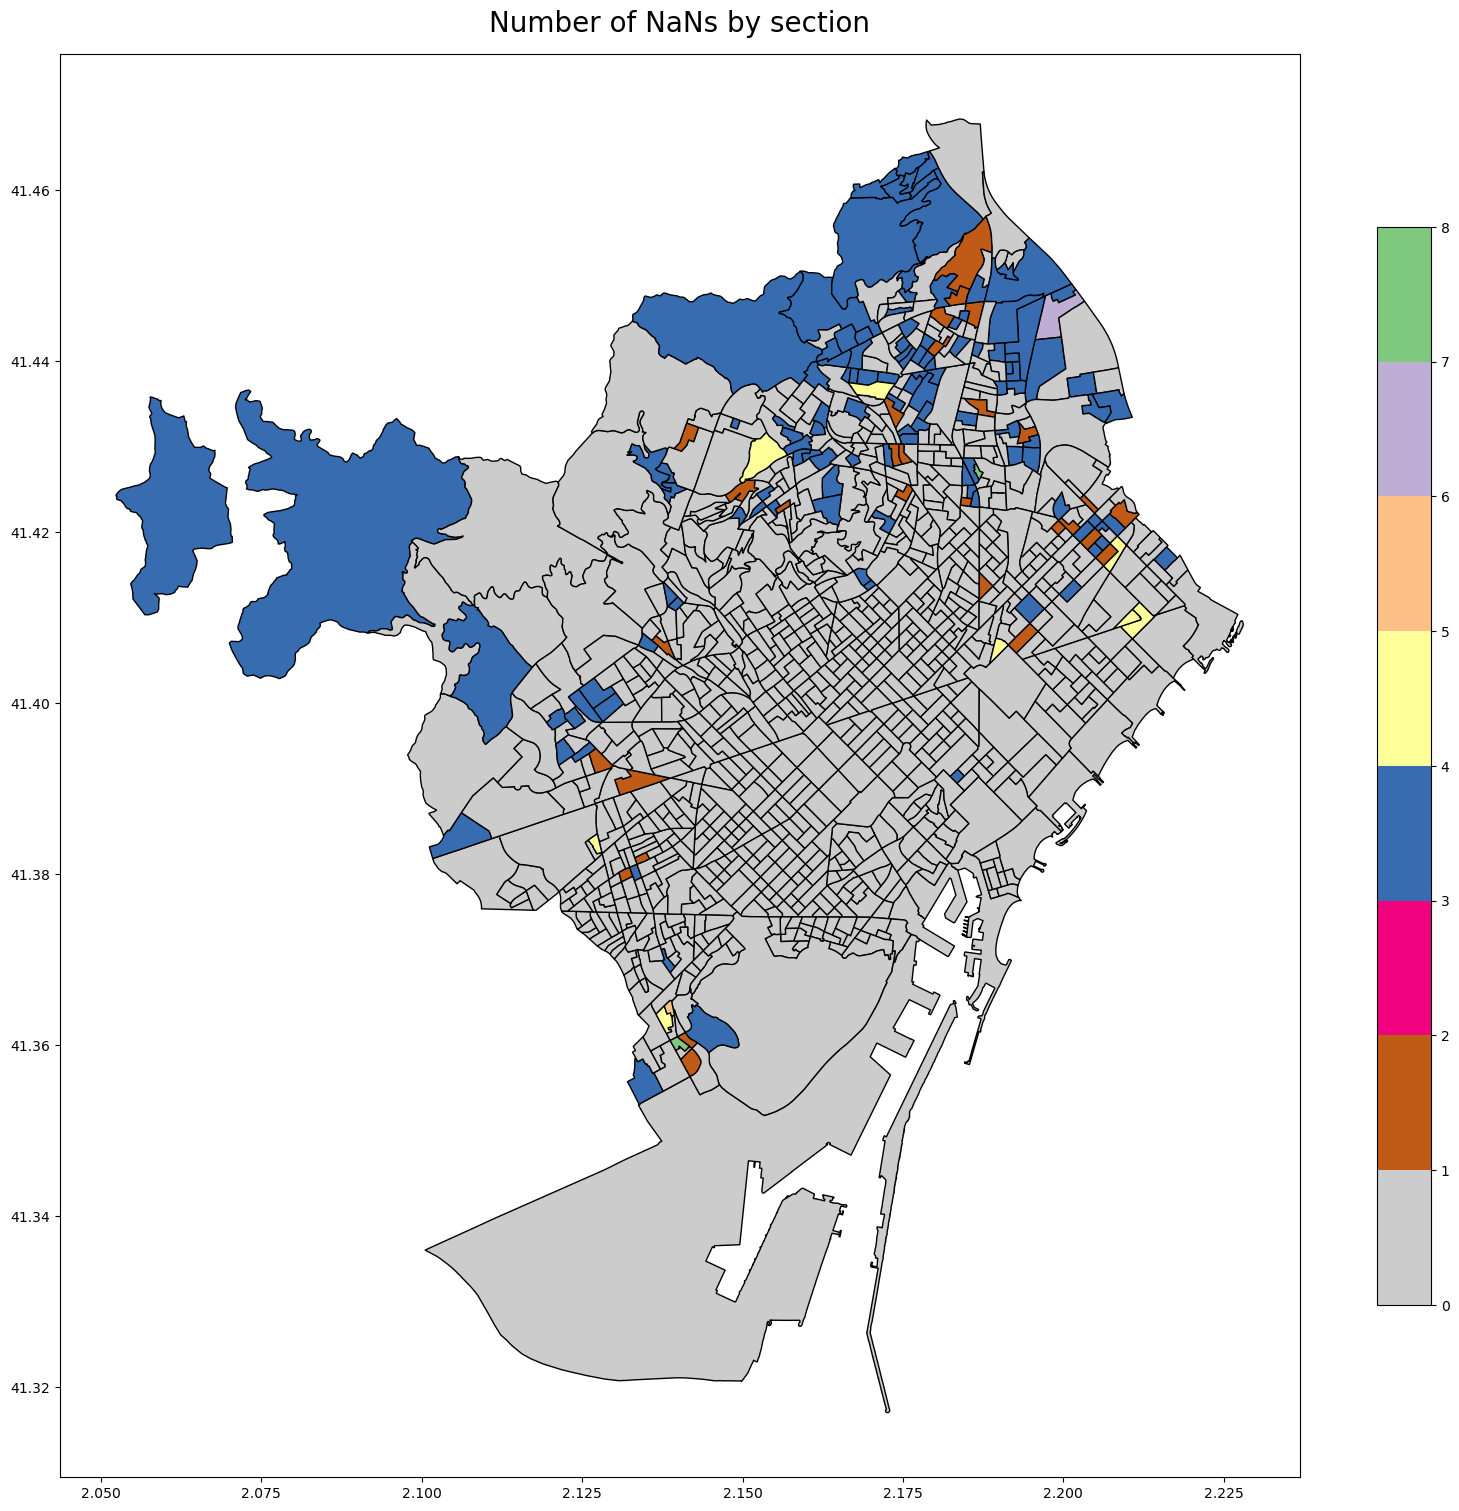

In [19]:
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor="black",
    legend=True,
    norm=my_norm,
    cmap=my_cmap,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by section", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_SVR / "nans.svg", format="svg")

plt.show()

# SVR Optimization


$$
\min_{\mathbf{w}, b, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

subject to:

$$
\begin{align*}
y_i - \mathbf{w}^T \mathbf{x}_i - b &\leq \epsilon + \xi_i \\
\mathbf{w}^T \mathbf{x}_i + b - y_i &\leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align*}
$$


In [20]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

X_train = X.to_numpy()
y_train = y.to_numpy()

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# coefficients and intercept
w = cp.Variable((X_train.shape[1], 1))
b = cp.Variable()

# SVR parameters: C (regularization) and epsilon (epsilon-insensitive zone)
C = 1024
epsilon = 0.1

# slack variables for the epsilon-insensitive zone
xi_pos = cp.Variable((X_train.shape[0], 1))
xi_neg = cp.Variable((X_train.shape[0], 1))

# OBJECTIVE FUNCTION
objective = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi_pos + xi_neg))

# CONSTRAINTS
constraints = [
    y_train.reshape(-1, 1) - cp.matmul(X_train, w) - b <= epsilon + xi_pos,
    cp.matmul(X_train, w) + b - y_train.reshape(-1, 1) <= epsilon + xi_neg,
    xi_pos >= 0,
    xi_neg >= 0,
]

# setting up and solving the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# coefficients and intercept
# print("Coefficients:", w.value)
print("Intercept:", b.value)

# train predictions
y_pred = np.matmul(X_train, w.value) + b.value

# mean squared error on train set
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error on train set:", mse)

# # mean squared error on test set
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error on test set:", mse)

Intercept: 13.730716191242935
Mean Squared Error on train set: 156.5460411571963


In [37]:
def train_svr(X, y, C, epsilon):

    np.random.seed(42)
    random.seed(42)

    imputer = KNNImputer()
    X = imputer.fit_transform(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # coefficients and intercept
    w = cp.Variable((X.shape[1], 1))
    b = cp.Variable()

    # slack variables for the epsilon-insensitive zone
    xi_pos = cp.Variable((X.shape[0], 1))
    xi_neg = cp.Variable((X.shape[0], 1))

    # OBJECTIVE FUNCTION
    objective = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi_pos + xi_neg))

    # CONSTRAINTS
    constraints = [
        y.reshape(-1, 1) - cp.matmul(X, w) - b <= epsilon + xi_pos,
        cp.matmul(X, w) + b - y.reshape(-1, 1) <= epsilon + xi_neg,
        xi_pos >= 0,
        xi_neg >= 0,
    ]

    # setting up and solving the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # model parameters and train set predictions
    y_pred = np.matmul(X, w.value) + b.value
    mse = mean_squared_error(y, y_pred)

    return w.value, b.value, y_pred, mse

In [38]:
# C_values = [1, 10, 100, 1000, 10000]
# # C_values = [1000]
# epsilon_values = [0.01]

# HPO grid definition
Cl = 0
Ch = 3
C_values = [2**l for l in range(Cl, Ch + 1)]  # C in a range from Cl to Ch
epsilon_values = [10**i for i in range(-2, 1)]

print(C_values)
print(epsilon_values)

results = {}
y_preds = {}
for C in C_values:
    for epsilon in epsilon_values:
        print(f"Training SVR with C={C} and epsilon={epsilon}")
        _, _, y_pred, mse = train_svr(X.to_numpy(), y.to_numpy(), C, epsilon)
        print(f"mse:{mse}")
        results[(C, epsilon)] = mse
        y_preds[(C, epsilon)] = y_pred

[1, 2, 4, 8]
[0.01, 0.1, 1]
Training SVR with C=1 and epsilon=0.01
mse:158.13432048124386
Training SVR with C=1 and epsilon=0.1
mse:158.50093639818678
Training SVR with C=1 and epsilon=1
mse:160.26593287943697
Training SVR with C=2 and epsilon=0.01
mse:157.9290223233163
Training SVR with C=2 and epsilon=0.1
mse:157.83952554859124
Training SVR with C=2 and epsilon=1
mse:159.5995648179595
Training SVR with C=4 and epsilon=0.01
mse:156.86638957873072
Training SVR with C=4 and epsilon=0.1
mse:156.91352020053753
Training SVR with C=4 and epsilon=1
mse:158.61419546479738
Training SVR with C=8 and epsilon=0.01
mse:156.17287147364453
Training SVR with C=8 and epsilon=0.1
mse:156.67995907319082
Training SVR with C=8 and epsilon=1
mse:157.67485785855487


Best parameters: C = 8.0; epsilon = 0.01


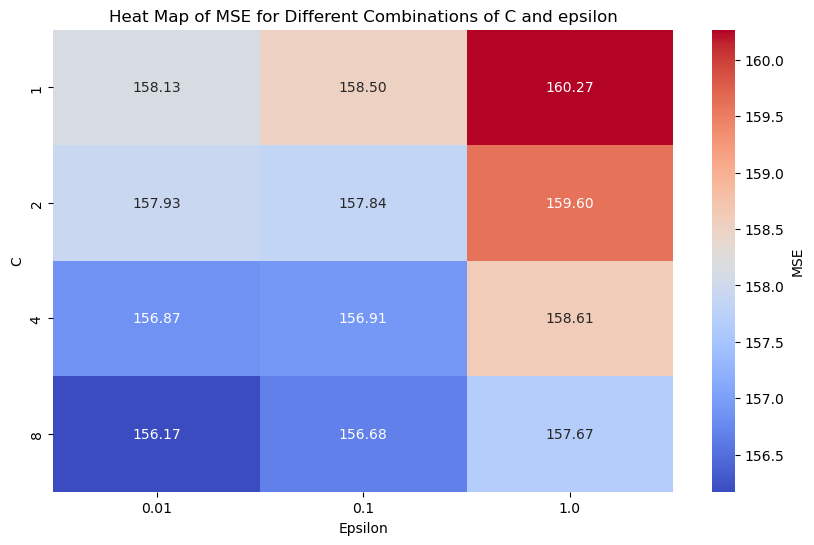

In [43]:
data = []
for (C, epsilon), mse in results.items():
    data.append({"C": C, "epsilon": epsilon, "MSE": mse})

df_results = pd.DataFrame(data)
result_matrix = df_results.pivot(index="C", columns="epsilon", values="MSE")

min_mse = df_results["MSE"].min()
best_params = df_results[df_results["MSE"] == min_mse]
best_C = best_params.iloc[0]["C"]
best_epsilon = best_params.iloc[0]["epsilon"]
print(f"Best parameters: C = {best_C}; epsilon = {best_epsilon}")

plt.figure(figsize=(10, 6))
sns.heatmap(
    result_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "MSE"}
)
plt.title("Heat Map of MSE for Different Combinations of C and epsilon")
plt.xlabel("Epsilon")
plt.ylabel("C")
plt.show()

### Model evaluation

(Of the best model)

In [46]:
y_truth = pd.Series(y, name="True Data")  # real y values:

y_pred = y_preds[best_C, best_epsilon]
y_pred = pd.Series(
    y_pred.flatten(), index=geo_info.index, name="SVR"
)  # relating the pred values with the geographical tags

#### Accuracy (Training) Representation

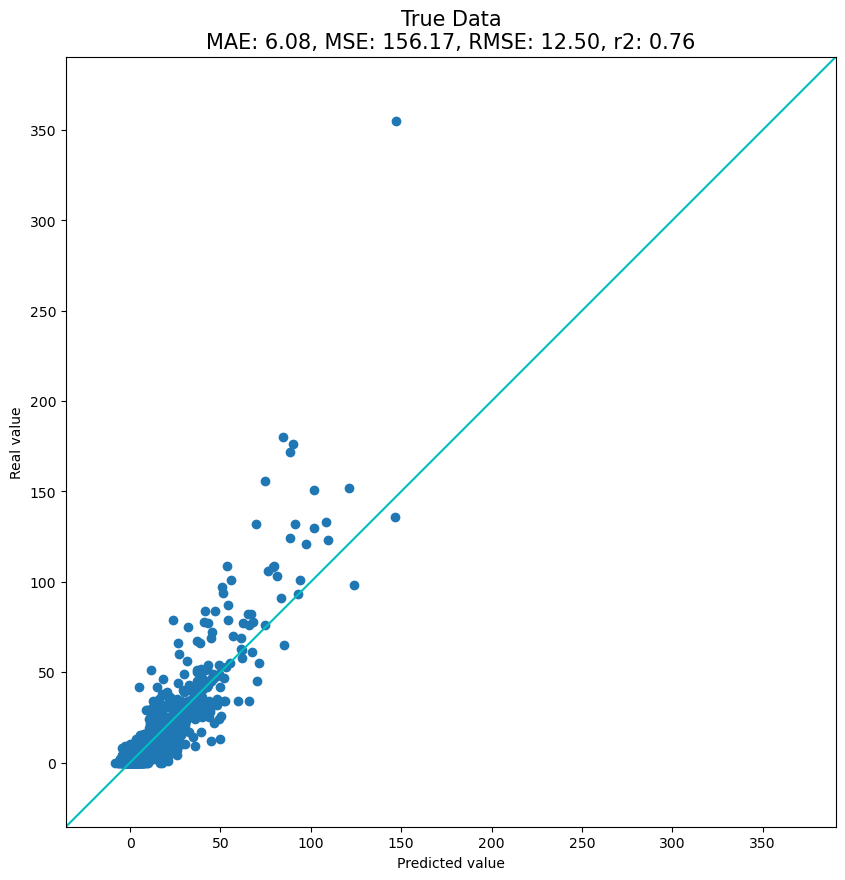

In [47]:
pa_svr = PredictedAccuracy(y_truth, y_pred)
pa_svr.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_alg_model")

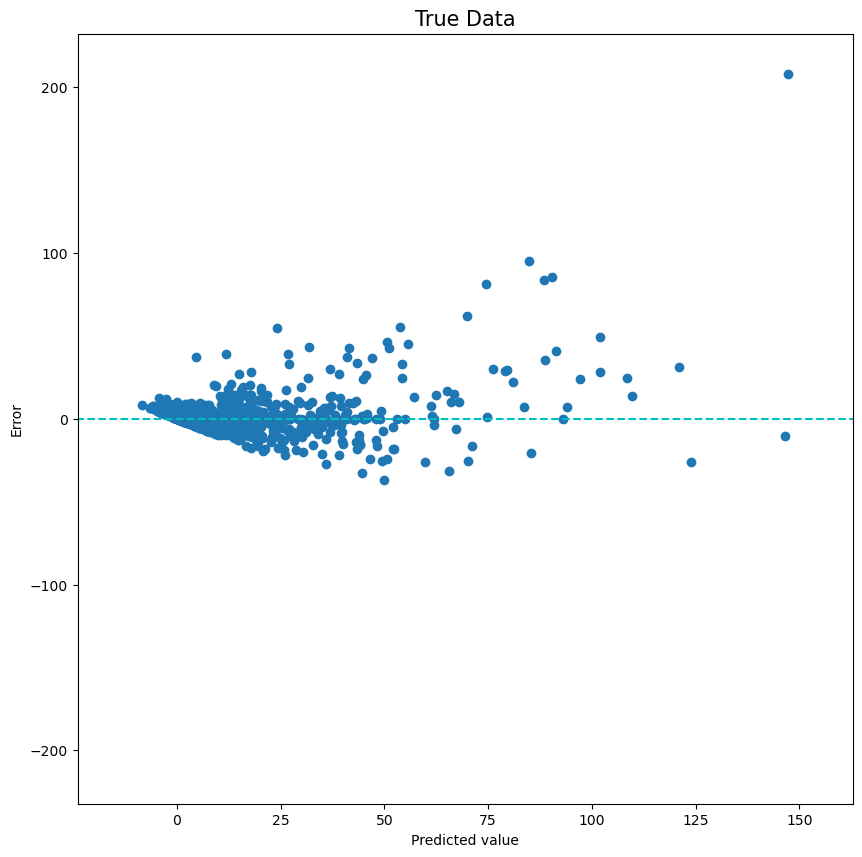

In [48]:
pa_svr.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_SVR / "svr_alg_model")

# Quadratic version: 

$$
\min_{\mathbf{w}, b, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

subject to:

$$
\begin{align*}
y_i - \mathbf{w}^T \mathbf{x}_i - b &\leq \epsilon + \xi_i \\
\mathbf{w}^T \mathbf{x}_i + b - y_i &\leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align*}
$$


$$
\min_{x, b, \xi, \xi^*} \frac{1}{2}x^{T}Px + q^{T}x
$$


subject to:

$$
\begin{align*}
Gx \leq h \\
Ax = b
\end{align*}
$$


In [27]:
X_train = X.to_numpy()
y_train = y.to_numpy()  # [:, np.newaxis]

print(f"X_train matrix shape: {X_train.shape}")
n, m = X_train.shape
print(f"y_train shape: {y_train.shape}")

# P matrix
P = np.zeros((m + 1 + n + n, m + 1 + n + n))
P[:m, :m] = 1

print(f"P matrix shape: {P.shape}")

e = np.ones(n)  # [:, np.newaxis]
print(f"e shape: {e.shape}")

I_n = np.identity(n)
I_nm = np.eye(n, m)

zero_nn = np.zeros((n, n))
zero_nm = np.zeros((n, m))
zero_mn = np.zeros((m, n))
zero_mm = np.zeros((m, m))
zero_n1 = np.zeros((n, 1))
zero_11 = np.zeros((1, 1))

G = np.block(
    [
        [-X_train, -np.ones(n)[:, np.newaxis], -I_n, zero_nn],
        [X_train, np.ones(n)[:, np.newaxis], zero_nn, -I_n],
        [zero_nm, zero_n1, -I_n, zero_nn],
        [zero_nm, zero_n1, zero_nn, -I_n],
    ]
)

print(f"G shape: (84*4, 1068+1+84*2) = {G.shape}")


C = 1024
epsilon = 0.01

q = np.zeros(m + 1 + 2 * n)[:, np.newaxis]
q[m + 1 : :] = C
print(f"q shape: = {q.shape}")

h1 = e * epsilon - y_train
h2 = e * epsilon + y_train
zero_n = np.zeros(n)  # [:, np.newaxis]
h = np.concatenate([h1, h2, zero_n, zero_n])  # 4nx1
print(f"h shape: = {h.shape}")

X_train matrix shape: (1068, 84)
y_train shape: (1068,)
P matrix shape: (2221, 2221)
e shape: (1068,)
G shape: (84*4, 1068+1+84*2) = (4272, 2221)
q shape: = (2221, 1)
h shape: = (4272,)


In [28]:
# Define and solve the CVXPY problem.
x = cp.Variable(m + 1 + n + n)
prob = cp.Problem(cp.Minimize((1 / 2) * cp.quad_form(x, P) + q.T @ x), [G @ x <= h])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.


SolverError: Workspace allocation error!

In [ ]:
print(m + 1 + 2 * n)

2221
